Transfer Learning is leveraging a working model's existing architecture and learned patterns to our own problem

There are two main benefits:
  1. Can leverage an existing NN architecture proven to work on problems similar to our own
  2. Can leverage a working NN architecture which has already learnt patterns on similar data to our won, then we can adapt those patterns to our own data

In [1]:
IMG_SHAPE = (224,224)
BATCH_SIZE = 32

### Downloading and becoming one with the Data

In [2]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-08-31 09:24:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.15.128, 173.194.76.128, 64.233.184.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  57.0MB/s    in 2.8s    

2021-08-31 09:24:54 (57.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os

for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [4]:
## Preparing the Data

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224,224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir="10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMG_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
test_data=test_datagen.flow_from_directory(test_dir,
                                           target_size=IMG_SIZE,
                                           batch_size=BATCH_SIZE,
                                           class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### Setting up callbacks

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks are:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with EarlyStopping callback

In [5]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d - %H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

#Creating models using TensorFlow Hub

In the past, we used TensorFlow to create our own models layer by layer from scratch

Now we're going to do a similar process except most of oue models layers are going to come from Tensorflow

We can access pretrained models on TensorFlow Hub



Model 1: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

Model 2: https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

#Let's compare the following 2 models

In [6]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
#Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
#Let's create create_model() to create a model from a URL
def create_model(model_url,num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url(str): A TensorFlow Hub feature extraction URL
    num_classes(int): Number of output neurons in the output layer

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
     layer  and Dense output layer with num_classes output neurons
  """

  feature_extractor_layer = hub.KerasLayer(model_url,
                                          trainable=False, #Freeze already trained parameters
                                          name = "feature_extraction_layer",
                                          input_shape=IMG_SHAPE+(3,))

  model=tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes,activation="softmax",name="Output_layer")
  ])
  return model


#Creating and test ResNet TensorFlow Hub Feattrue Extraction Model

In [9]:
resnet_model=create_model(resnet_url,num_classes=train_data_10_percent.num_classes)

In [10]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [11]:
#Let's fit our ResNet model to the data (10 percent of our whole data)
resnet_history = resnet_model.fit(train_data_10_percent,epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20210831 - 092510
Epoch 1/5
24/24 [==============================] - 57s 1s/step - loss: 1.7815 - accuracy: 0.3960 - val_loss: 1.2166 - val_accuracy: 0.5992
Epoch 2/5
24/24 [==============================] - 22s 936ms/step - loss: 0.8655 - accuracy: 0.7360 - val_loss: 0.8549 - val_accuracy: 0.7224
Epoch 3/5
24/24 [==============================] - 22s 938ms/step - loss: 0.5885 - accuracy: 0.8373 - val_loss: 0.7651 - val_accuracy: 0.7508
Epoch 4/5
24/24 [==============================] - 22s 943ms/step - loss: 0.4560 - accuracy: 0.8733 - val_loss: 0.7085 - val_accuracy: 0.7716
Epoch 5/5
24/24 [==============================] - 22s 939ms/step - loss: 0.3563 - accuracy: 0.9253 - val_loss: 0.7031 - val_accuracy: 0.7644


In [12]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  loss=history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]
  epochs=tf.range(len(loss))

  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("Loss curve")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()

  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("Accuracy curve")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.plot()

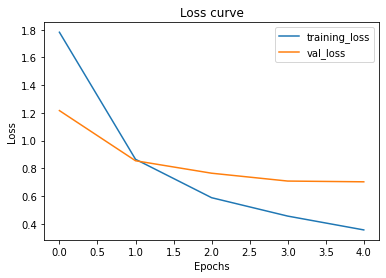

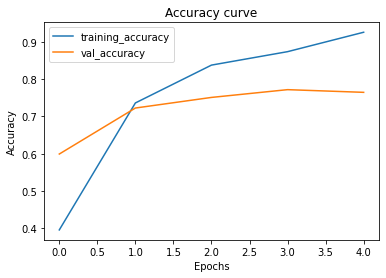

In [13]:
plot_loss_curves(resnet_history)

In [14]:
#Let's noe make EfficientNet model

efficientnet_model=create_model(efficientnet_url,
                                num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_data_10_percent,epochs=5,
                                           steps_per_epoch=len(train_data_10_percent),
                                           validation_data=test_data,
                                           callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                  experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20210831 - 092751
Epoch 1/5
24/24 [==============================] - 33s 989ms/step - loss: 1.8929 - accuracy: 0.4520 - val_loss: 1.3534 - val_accuracy: 0.7236
Epoch 2/5
24/24 [==============================] - 19s 802ms/step - loss: 1.0802 - accuracy: 0.7960 - val_loss: 0.8838 - val_accuracy: 0.8252
Epoch 3/5
24/24 [==============================] - 19s 799ms/step - loss: 0.7548 - accuracy: 0.8440 - val_loss: 0.7066 - val_accuracy: 0.8404
Epoch 4/5
24/24 [==============================] - 18s 792ms/step - loss: 0.6056 - accuracy: 0.8693 - val_loss: 0.6149 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 18s 793ms/step - loss: 0.5123 - accuracy: 0.8987 - val_loss: 0.5593 - val_accuracy: 0.8628


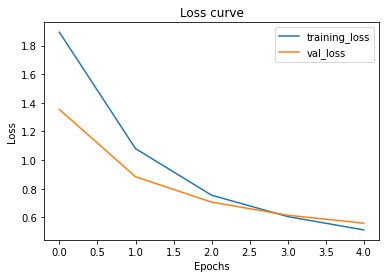

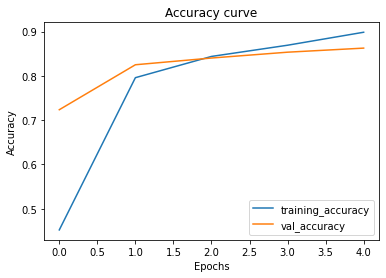

In [15]:
plot_loss_curves(efficientnet_history)

#Comparing our model results using TensorBoard
**Note:** When you ipload things to TensorBoard.dev, your experiments will be public

In [17]:
#Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "efficientNetB0 vs ResNet50V2" \
  --description "Comparing two different TFHub feature extraction models using 10% training data" \
  --one_shot

2021-08-31 09:30:13.882249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 09:30:13.906097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 09:30:13.906613: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privac

Our TensorBoard experiments are uploaded to https://tensorboard.dev/experiment/mDTm8eG3RvaqzESZ6XDK7Q/

In [18]:
!tensorboard dev list #Lists all experriments on tensorboard dev

2021-08-31 09:35:15.432640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 09:35:15.447231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-31 09:35:15.447755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/mDTm8eG3RvaqzESZ6XDK7Q/
	Name                 efficientNetB0 vs ResNet50V2
	Description          Comparing two different TFHub feature extraction models using 10% training data
	Id                   mDTm8eG3RvaqzESZ6XDK7Q
	Created              2021-08-31 09:31:17 (4 minutes ago)
	Updated              202

In [19]:
#Deleting an experiment
#!tensorboard dev delete --experiment_id <Id>

In [20]:
#Confirm the deletion by rechecking what experiments you have left